In [1]:
#!/usr/bin/env python
# coding: utf-8
import sys
import scanpy as sc
import scanpy.external as sce
import anndata
import pandas as pd
import numpy as np
import os
import gc
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import bbknn

In [2]:
def read_and_qc(sample_name, path, force_filter = True):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name) + '/outs',
                           count_file='filtered_feature_bc_matrix.h5', 
                           load_images=False)
    
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.var['rps'] = [gene.startswith('RPS') for gene in adata.var['SYMBOL']]
    adata.var['mrp'] = [gene.startswith('MRP') for gene in adata.var['SYMBOL']]
    adata.var['rpl'] = [gene.startswith('RPL') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:,adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    adata.var["duplicated"] = adata.var['SYMBOL'].duplicated(keep = "first")
    adata = adata[:, ~adata.var['duplicated'].values]
    
    if force_filter:
        # First filter: mt and rb genes
        # mitochondria-encoded (MT) genes should be removed for spatial mapping
        adata.obsm['mt'] = adata[:,   adata.var['mt'].values | 
                              adata.var['rps'].values |
                              adata.var['mrp'].values |
                              adata.var['rpl'].values].X.toarray() 
        
        adata = adata[:, ~ (adata.var['mt'].values | 
                              adata.var['rps'].values |
                              adata.var['mrp'].values |
                              adata.var['rpl'].values)]
        
        # Second filter
        # Genes expressed in less than 10 spots
        adata = adata[:, adata.var['n_cells_by_counts'].values > 10]
        
        # Third filter
        # spots with no information (less than 300 genes and 500 UMIs)
        sc.pp.calculate_qc_metrics(adata, inplace=True)
        adata = adata[(adata.obs['n_genes_by_counts'].values > 300) & 
              (adata.obs['total_counts'].values > 500), :] 
        

    return adata

In [3]:
#adata stuff
sp_data_folder = "/Users/ricardoramirez/Dropbox/PhD/Research/mi_atlas/visium_data/"
sample_names = [i for i in os.listdir(sp_data_folder) if i != ".DS_Store"]
sample_names = sample_names[0:11]

In [4]:
#######################
# Read the data into anndata objects
slides = []
for i in sample_names:
    slide_i = read_and_qc(i, path = sp_data_folder, force_filter = True)
    sc.pp.normalize_total(slide_i, target_sum=1e4)
    # Log transform
    sc.pp.log1p(slide_i)
    slides.append(slide_i)

# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    batch_key="sample",
    uns_merge="unique",
    batch_categories=sample_names,
    index_unique=None
)

del slides

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
/Users/ricardoramirez/opt/miniconda3/envs/cellpymc/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_nam

In [5]:
adata.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_frac
spot_id,,,,,,,,,,
Visium_7_CK285_AAACAACGAATAGTTC-1,Visium_7_CK285,1831,7.513164,3092.0,8.036897,20.375162,27.846054,38.195343,56.953428,0.177957
Visium_7_CK285_AAACAAGTATCTCCCA-1,Visium_7_CK285,3905,8.270269,9558.0,9.165238,21.500314,28.269512,36.398828,50.502197,0.042848
Visium_7_CK285_AAACAATCTACTAGCA-1,Visium_7_CK285,1866,7.532088,3347.0,8.116118,23.872124,30.833582,40.663281,59.037944,0.247531
Visium_7_CK285_AAACAGAGCGACTCCT-1,Visium_7_CK285,3235,8.082093,7496.0,8.922258,23.038954,30.696371,38.980790,53.308431,0.052940
Visium_7_CK285_AAACATTTCCCGGATT-1,Visium_7_CK285,2760,7.923348,6122.0,8.719808,22.803006,30.708919,40.068605,55.276054,0.123254
...,...,...,...,...,...,...,...,...,...,...
Visium_1_CK279_TTGTGTTTCCCGAAAG-1,Visium_1_CK279,1291,7.163947,2399.0,7.783224,30.179241,38.516048,48.812005,67.027928,0.474666
Visium_1_CK279_TTGTTGTGTGTCAAGA-1,Visium_1_CK279,1345,7.204893,2529.0,7.835975,28.390668,37.406089,48.319494,66.587584,0.454772
Visium_1_CK279_TTGTTTCACATCCAGG-1,Visium_1_CK279,998,6.906755,1611.0,7.385231,26.753569,36.685289,49.099938,69.087523,0.340487


In [5]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, 
                            min_disp=0.5, batch_key='sample')

# Save raw gene expression
adata.raw = adata
adata.uns['hvg']['ngene'] = adata.shape[1]

# Filter HVG. 
# Select top 3000 HVG in as much batches as possible
# Genes need to be HV in at least 2 batches
num_hvg_genes = 3000
batch_msk = np.array(adata.var.highly_variable_nbatches > 1)
hvg = adata.var[batch_msk].sort_values('highly_variable_nbatches').tail(num_hvg_genes).index
adata = adata[:, hvg]
print("Shape:", adata.shape)

# Update QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Compute PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


... storing 'feature_types' as categorical
... storing 'genome' as categorical
/Users/ricardoramirez/opt/miniconda3/envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/ricardoramirez/opt/miniconda3/envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Shape: (34931, 3000)


Trying to set attribute `.obs` of view, copying.


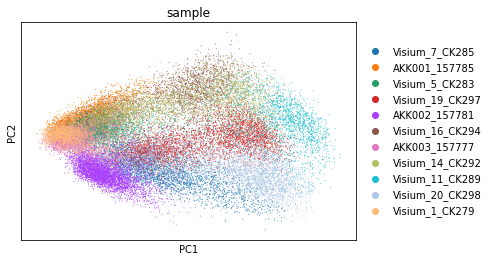

In [7]:
sc.pl.pca(adata,color="sample")

In [8]:
sce.pp.bbknn(adata, batch_key= 'sample')

In [9]:
sc.tl.umap(adata)

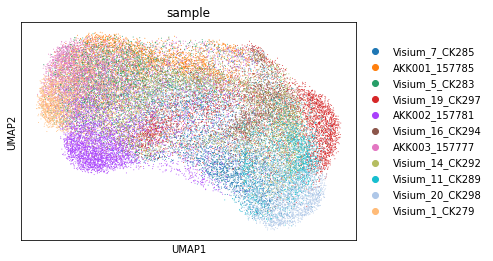

In [10]:
sc.pl.umap(adata,color="sample")

In [11]:
sce.pp.harmony_integrate(adata, 'sample', 
                             adjusted_basis='X_pca', 
                             max_iter_harmony=30)
    
    # Compute NN using updated PCA
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

2021-08-04 18:00:30,995 - harmonypy - INFO - Iteration 1 of 30
2021-08-04 18:00:42,914 - harmonypy - INFO - Iteration 2 of 30
2021-08-04 18:00:53,951 - harmonypy - INFO - Converged after 2 iterations


In [12]:
sc.tl.umap(adata)

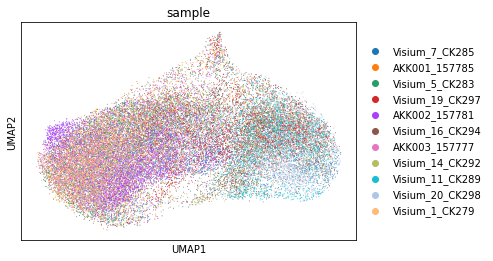

In [13]:
sc.pl.umap(adata,color="sample")

In [14]:
sc.tl.pca(adata, svd_solver='arpack')

/Users/ricardoramirez/opt/miniconda3/envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
sce.pp.scanorama_integrate(adata, 'sample')

[[0.         0.09412528 0.21933296 0.10708202 0.40575354 0.07925311
  0.12511118 0.0337356  0.12010582 0.41226078 0.10132159]
 [0.         0.         0.49107433 0.04608893 0.01720221 0.40344044
  0.49334632 0.16293411 0.02539683 0.00908796 0.33871757]
 [0.         0.         0.         0.04578858 0.03759186 0.40165975
  0.61873703 0.17225806 0.11269841 0.02035048 0.44836025]
 [0.         0.         0.         0.         0.01703578 0.34149378
  0.01046483 0.0734972  0.47671958 0.46458992 0.00632757]
 [0.         0.         0.         0.         0.         0.02365145
  0.03409428 0.00387097 0.01904762 0.07103471 0.01762115]
 [0.         0.         0.         0.         0.         0.
  0.1406639  0.66390041 0.34603175 0.03941909 0.16642193]
 [0.         0.         0.         0.         0.         0.
  0.         0.07935484 0.00634921 0.00389231 0.53957901]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.43968254 0.04995135 0.07244249]
 [0.         0. 

In [13]:
'X_scanorama' in adata.obsm

True

In [16]:
sc.pp.neighbors(adata, use_rep="X_scanorama")
sc.tl.umap(adata)

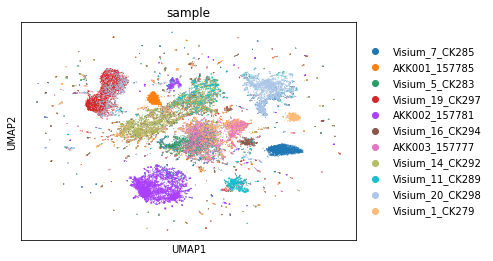

In [17]:
sc.pl.umap(adata, color="sample")

In [2]:
sc.__version__

'1.8.1'

AttributeError: module 'bbknn' has no attribute '__version__'

In [9]:
adata.obsm["X_scanorama"]

KeyError: 'X_scanorama'

In [10]:
adata.obs

,sample,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,mt_frac,total_counts_mt,pct_counts_mt
spot_id,,,,,,,,,,,,
Visium_7_CK285_AAACAACGAATAGTTC-1,Visium_7_CK285,402,7.513164,682.317566,8.036897,20.375162,27.846054,38.195343,56.953428,0.177957,0.0,0.0
Visium_7_CK285_AAACAAGTATCTCCCA-1,Visium_7_CK285,773,8.270269,800.206909,9.165238,21.500314,28.269512,36.398828,50.502197,0.042848,0.0,0.0
Visium_7_CK285_AAACAATCTACTAGCA-1,Visium_7_CK285,423,7.532088,704.700195,8.116118,23.872124,30.833582,40.663281,59.037944,0.247531,0.0,0.0
Visium_7_CK285_AAACAGAGCGACTCCT-1,Visium_7_CK285,665,8.082093,799.876648,8.922258,23.038954,30.696371,38.980790,53.308431,0.052940,0.0,0.0
Visium_7_CK285_AAACATTTCCCGGATT-1,Visium_7_CK285,579,7.923348,761.332703,8.719808,22.803006,30.708919,40.068605,55.276054,0.123254,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
Visium_1_CK279_TTGTGTTTCCCGAAAG-1,Visium_1_CK279,235,7.163947,451.134308,7.783224,30.179241,38.516048,48.812005,67.027928,0.474666,0.0,0.0
Visium_1_CK279_TTGTTGTGTGTCAAGA-1,Visium_1_CK279,247,7.204893,466.527710,7.835975,28.390668,37.406089,48.319494,66.587584,0.454772,0.0,0.0
Visium_1_CK279_TTGTTTCACATCCAGG-1,Visium_1_CK279,207,6.906755,454.367554,7.385231,26.753569,36.685289,49.099938,69.087523,0.340487,0.0,0.0
